In [1]:
import os
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.nn import weighted_cross_entropy_with_logits as weighted_loss

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Add, Dense, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE

#!rm -rf ./logs/

%load_ext tensorboard
%load_ext pycodestyle_magic

THRESHOLD = 0.3
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 1
IMAGE_PX = 128
LEARNING_RATE = 1e-3
LOSS_WEIGHT = 5
STEPS_PER_EPOCH = 10

BASE_PATH = './LEVIR-CD/'
CHECKPOINT_PATH = "./checkpoints/cp.ckpt"
LOG_PATH = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [2]:
%flake8_on --max_line_length 115
def process_path(a_path):
    def prepare_image(path, channels):
        res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
        res = tf.image.convert_image_dtype(res, tf.float32)
        return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])

    b_path = tf.strings.regex_replace(a_path, '/A/', '/B/')
    label_path = tf.strings.regex_replace(a_path, '/A/', '/label/')
    
    return (concatenate([prepare_image(a_path, CHANNELS),
                         prepare_image(b_path, CHANNELS)], axis=2),
            prepare_image(label_path, 1))


def deconcatenate(x):
    return x[:, :, :, 0:3], x[:, :, :, 3:6]


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.cache().shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat().batch(BATCH_SIZE)
    return ds.prefetch(buffer_size=AUTOTUNE)


def weighted_bce_dice_loss(y_true, y_pred):
    return tf.reduce_mean(weighted_loss(y_true, y_pred,
                                        LOSS_WEIGHT))


def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, mode='None'):
    x = Conv2D(nb_filter,
               (kernel_size, kernel_size),
               activation='selu',
               name='conv' + stage + '_1',
               kernel_initializer='he_normal',
               padding='same',
               kernel_regularizer=l2(1e-4))(input_tensor)
    x0 = x
    x = BatchNormalization(name='bn' + stage + '_1')(x)
    x = Conv2D(nb_filter,
               (kernel_size, kernel_size),
               activation='selu',
               name='conv' + stage + '_2',
               kernel_initializer='he_normal',
               padding='same',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(name='bn' + stage + '_2')(x)
    if mode == 'residual':
        x = Add(name='resi' + stage)([x, x0])
    return x

In [3]:
def Nest_Net2(input_shape, num_class=1):
    # nb_filter = [16, 32, 64, 128, 256]
    nb_filter = [32, 64, 128, 256, 512]
    mode = 'residual'
    bn_axis = 3

    inputs = Input(shape=input_shape)
    conv1_1 = standard_unit(inputs, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1], mode=mode)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0], mode=mode)

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2], mode=mode)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1], mode=mode)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0], mode=mode)

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3], mode=mode)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2], mode=mode)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1], mode=mode)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0], mode=mode)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4], mode=mode)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3], mode=mode)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2], mode=mode)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1], mode=mode)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0], mode=mode)
    
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4',
                          kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    conv_fuse = concatenate([conv1_2, conv1_3, conv1_4, conv1_5], name='merge_fuse', axis=bn_axis)
    nestnet_output_5 = Conv2D(num_class, (1, 1),
                              activation='sigmoid', name='output_5',
                              kernel_initializer='he_normal', padding='same',
                              kernel_regularizer=l2(1e-4))(conv_fuse)

    metrics = [tf.keras.metrics.BinaryAccuracy(threshold=THRESHOLD,
                                               name='accuracy'),
               tf.keras.metrics.Precision(thresholds=THRESHOLD,
                                          name='precision'),
               tf.keras.metrics.Recall(thresholds=THRESHOLD,
                                       name='recall')]

    model = Model(inputs=inputs, outputs=[nestnet_output_5])
    model.compile(optimizer=Adam(lr=LEARNING_RATE),
                  loss=weighted_bce_dice_loss,
                  metrics=metrics)

    # model.summary()
    return model

61:1: W293 blank line contains whitespace
62:5: F841 local variable 'nestnet_output_4' is assigned to but never used
63:27: E128 continuation line under-indented for visual indent


In [4]:
train_path_list = tf.data.Dataset.list_files(BASE_PATH + 'train/A/*.png')
test_path_list = tf.data.Dataset.list_files(BASE_PATH + 'test/A/*.png')
val_path_list = tf.data.Dataset.list_files(BASE_PATH + 'val/A/*.png')

train_ds = train_path_list.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_path_list.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_path_list.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

input_shape = [IMAGE_PX, IMAGE_PX, CHANNELS * 2]
model = Nest_Net2(input_shape)

In [5]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor='accuracy',
                                                         mode='max',
                                                         verbose=0,
                                                         save_freq='epoch')

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH, histogram_freq=1)

In [6]:
try:
    model.load_weights(tf.train.latest_checkpoint(os.path.dirname(CHECKPOINT_PATH)))
except AttributeError:
    pass

model.fit(train_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=EPOCHS,
          validation_data=val_ds,
          callbacks=[tensorboard_callback, checkpoint_callback])

10/10 [==============================] - 58s 6s/step - loss: 1.1500 - accuracy: 0.9492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0826 - val_accuracy: 0.9548 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [7]:
def target_dim(channels):
    return [1, IMAGE_PX, IMAGE_PX, channels]


x, label = next(iter(test_ds.take(1)))
a, b = deconcatenate(x)
raw_pred = model.predict(x)
if isinstance(raw_pred, list):
    raw_pred = raw_pred[-1]
bool_pred = tf.cast(tf.greater_equal(raw_pred, 0.6), tf.float32)

file_writer = tf.summary.create_file_writer(LOG_PATH)
for i in range(BATCH_SIZE):
    with file_writer.as_default():
        tf.summary.image("Image {} A".format(i + 1), tf.reshape(a[i, :, :, :], target_dim(3)), step=0)
        tf.summary.image("Image {} B".format(i + 1), tf.reshape(b[i, :, :, :], target_dim(3)), step=0)
        tf.summary.image("Image {} Groundtruth".format(i + 1), tf.reshape(label[i], target_dim(1)), step=0)
        tf.summary.image("Image {} Raw Prediction".format(i + 1), tf.reshape(raw_pred[i], target_dim(1)), step=0)
        tf.summary.image("Image {} Boolean Prediction".format(i + 1), tf.reshape(bool_pred[i], target_dim(1)), step=0)

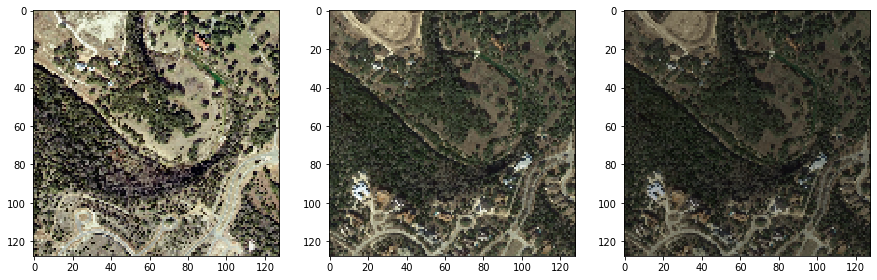

In [8]:
index = 12

a, b = deconcatenate(x)
a = x[:, :, :, 0:3]
b = x[:, :, :, 3:6]

raw_pred_c = tf.image.grayscale_to_rgb(tf.constant(raw_pred[index, :, :])).numpy()
raw_pred_c[:, :, 1] = 0
raw_pred_c[:, :, 2] = 0

bool_pred_c = tf.image.grayscale_to_rgb(bool_pred[index, :, :]).numpy()
bool_pred_c[:, :, 1] = 0
bool_pred_c[:, :, 2] = 0

plt.figure(figsize=(15, 45))
plt.subplot(131)
plt.imshow(a[index, :, :, :])


plt.subplot(132)
plt.imshow(b[index, :, :, :])

plt.subplot(133)
plt.imshow(b[index, :, :, :], alpha=1)
plt.imshow(bool_pred_c, alpha=0.3)

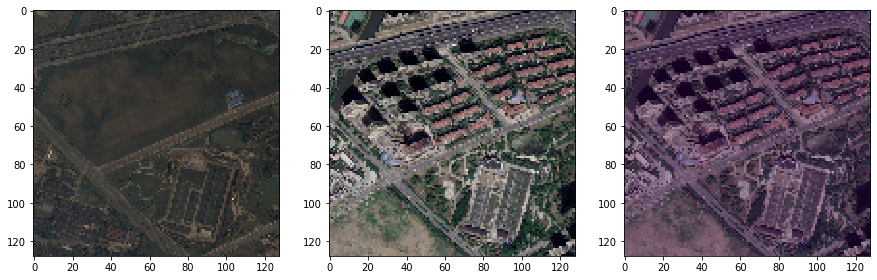

In [9]:
a_path = './test_set/1/Before.png'
b_path = './test_set/1/After.png'


def prepare_image(path, channels):
    res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
    res = tf.image.convert_image_dtype(res, tf.float32)
    return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])


a = prepare_image(a_path, 3)
b = prepare_image(b_path, 3)

x = concatenate([a, b], axis=2)

x = x[tf.newaxis, ...]

predd = tf.squeeze(model.predict(x)[0])

plt.figure(figsize=(15, 45))

plt.subplot(131)
plt.imshow(a)


plt.subplot(132)
plt.imshow(b)

plt.subplot(133)
plt.imshow(b, alpha=1)
plt.imshow(predd, alpha=0.3)